In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
female = torchvision.datasets.ImageFolder('/content/drive/My Drive/faces94/female', transform=transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]))
male = torchvision.datasets.ImageFolder('/content/drive/My Drive/faces94/male', transform=transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]))
malestaff = torchvision.datasets.ImageFolder('/content/drive/My Drive/faces94/malestaff', transform=transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]))

In [ ]:
Dataloader = [torch.utils.data.DataLoader(female, batch_size=128, shuffle=True, num_workers=8), 
              torch.utils.data.DataLoader(male, batch_size=128, shuffle=True, num_workers=8), 
              torch.utils.data.DataLoader(malestaff, batch_size=128, shuffle=True, num_workers=8)] 

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

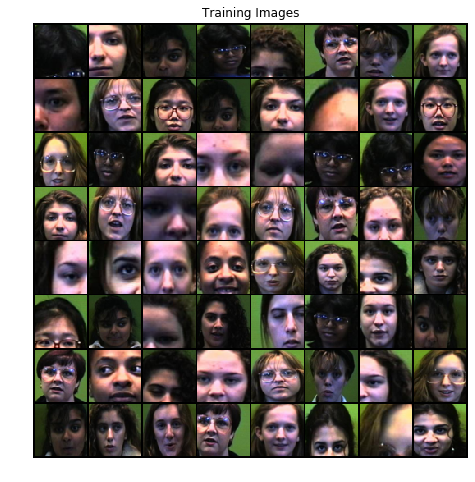

In [6]:
real_batch = next(iter(Dataloader[0]))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [ ]:
def initialize_weights(arg_class):
  class_name = arg_class.__class__.__name__
  if class_name.find('Conv') != -1:
    torch.nn.init.normal_(arg_class.weight.data, 0.0, 0.02)
  elif class_name.find('BatchNorm') != -1:
    torch.nn.init.normal_(arg_class.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(arg_class.bias.data, 0)

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.encoder = torch.nn.Sequential(
                                       torch.nn.Conv2d(3, 64, 4, 2, 1, bias = False),
                                       torch.nn.LeakyReLU(0.2, inplace=True),
                                       torch.nn.Conv2d(64, 128, 4, 2, 1, bias = False),
                                       torch.nn.BatchNorm2d(128),
                                       torch.nn.LeakyReLU(0.2, inplace=True),
                                       torch.nn.Conv2d(128, 256, 4, 2, 1, bias = False),
                                       torch.nn.BatchNorm2d(256),
                                       torch.nn.LeakyReLU(0.2, inplace=True),
                                       torch.nn.Conv2d(256, 512, 4, 2, 1, bias = False),
                                       torch.nn.BatchNorm2d(512),
                                       torch.nn.LeakyReLU(0.2, inplace=True),
                                       torch.nn.Conv2d(512, 100, 4, 1, 0, bias = False),
                                      )
  def forward(self, inp):
    return self.encoder(inp)
class Decoder(torch.nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.decoder = torch.nn.Sequential(
                                   torch.nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
                                   torch.nn.BatchNorm2d(512),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
                                   torch.nn.BatchNorm2d(256),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                                   torch.nn.BatchNorm2d(128),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                                   torch.nn.BatchNorm2d(64),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
                                   torch.nn.Tanh()
                                   )
  def forward(self, inp):
    return (self.decoder(inp))
class Generator(torch.nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
  def forward(self, inp):
    return self.decoder(self.encoder(inp))

class Discriminator(torch.nn.Module):
  def __init__(self, feature_maps):
    super(Discriminator, self).__init__()
    self.feature_maps = feature_maps
    self.main = torch.nn.Sequential(torch.nn.Conv2d(3, feature_maps, 4, 2, 1, bias = False),
                                   torch.nn.LeakyReLU(0.2, inplace=True),
                                   torch.nn.Conv2d(feature_maps, feature_maps*2, 4, 2, 1, bias = False),
                                   torch.nn.BatchNorm2d(feature_maps*2),
                                   torch.nn.LeakyReLU(0.2, inplace=True),
                                   torch.nn.Conv2d(feature_maps*2, feature_maps*4, 4, 2, 1, bias = False),
                                   torch.nn.BatchNorm2d(feature_maps*4),
                                   torch.nn.LeakyReLU(0.2, inplace=True),
                                   torch.nn.Conv2d(feature_maps*4, feature_maps*8, 4, 2, 1, bias = False),
                                   torch.nn.BatchNorm2d(feature_maps*8),
                                   torch.nn.LeakyReLU(0.2, inplace=True),
                                   torch.nn.Conv2d(feature_maps*8, 3, 4, 1, 0, bias = False),
                                   torch.nn.Sigmoid())
  def forward(self, input_image):
    return self.main(input_image)

In [9]:
generator = Generator().to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
print(generator)

Generator(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace)
      (11): Conv2d(512, 100, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
  )
  (decoder): Deco

In [10]:
discriminator = Discriminator(64).to(device)
discriminator.apply(initialize_weights)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 3, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
iterations = 0
generator.to(device)
for epoch in range(150):
  for j in range(len(Dataloader)):
    total_loss = 0
    for i, data in enumerate(Dataloader[j], 0):
      optimizer.zero_grad()
      batch = data[0].to(device)
      batch_size = batch.size(0)
      gained_image = generator(batch)
      gained_loss=loss(gained_image, batch)
      total_loss += gained_loss.mean().item()
      gained_loss.backward()
      optimizer.step()
  print("EPOCH:", epoch+1)
  print("AVERAGE LOSS:", total_loss)

EPOCH: 1
AVERAGE LOSS: 0.7350614964962006
EPOCH: 2
AVERAGE LOSS: 0.5225824490189552
EPOCH: 3
AVERAGE LOSS: 0.40835852921009064
EPOCH: 4
AVERAGE LOSS: 0.33655911684036255
EPOCH: 5
AVERAGE LOSS: 0.30064427852630615
EPOCH: 6
AVERAGE LOSS: 0.2645224444568157
EPOCH: 7
AVERAGE LOSS: 0.2516770400106907
EPOCH: 8
AVERAGE LOSS: 0.23429188504815102
EPOCH: 9
AVERAGE LOSS: 0.2207176759839058
EPOCH: 10
AVERAGE LOSS: 0.20316863059997559
EPOCH: 11
AVERAGE LOSS: 0.19576292857527733
EPOCH: 12
AVERAGE LOSS: 0.19196820259094238
EPOCH: 13
AVERAGE LOSS: 0.18542681261897087
EPOCH: 14
AVERAGE LOSS: 0.1838337555527687
EPOCH: 15
AVERAGE LOSS: 0.18227487802505493
EPOCH: 16
AVERAGE LOSS: 0.1727333664894104
EPOCH: 17
AVERAGE LOSS: 0.16709329932928085
EPOCH: 18
AVERAGE LOSS: 0.1624392420053482
EPOCH: 19
AVERAGE LOSS: 0.1554129682481289
EPOCH: 20
AVERAGE LOSS: 0.15893133357167244
EPOCH: 21
AVERAGE LOSS: 0.17885557562112808
EPOCH: 22
AVERAGE LOSS: 0.15210820361971855
EPOCH: 23
AVERAGE LOSS: 0.14368189498782158
EPOCH:

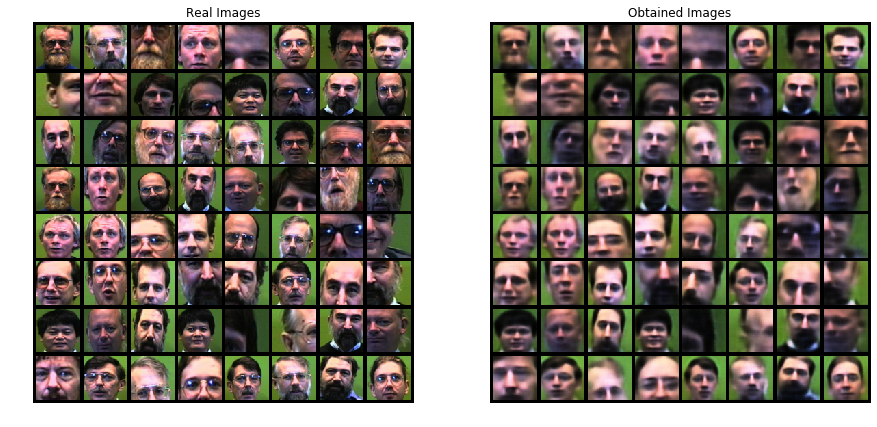

In [12]:
with torch.no_grad():
  real_batch = next(iter(Dataloader[2]))
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Obtained Images")
  plt.imshow(np.transpose(torchvision.utils.make_grid(generator(real_batch[0].to(device)[:64]), padding=5, normalize=True).cpu(),(1,2,0)))
  plt.show()

In [ ]:
loss = torch.nn.BCELoss()
test_noise = torch.randn(64, 3, 64, 64, device = device)

In [ ]:
fake = 0
real = 1
generatorOptimizer = torch.optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
discriminatorOptimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

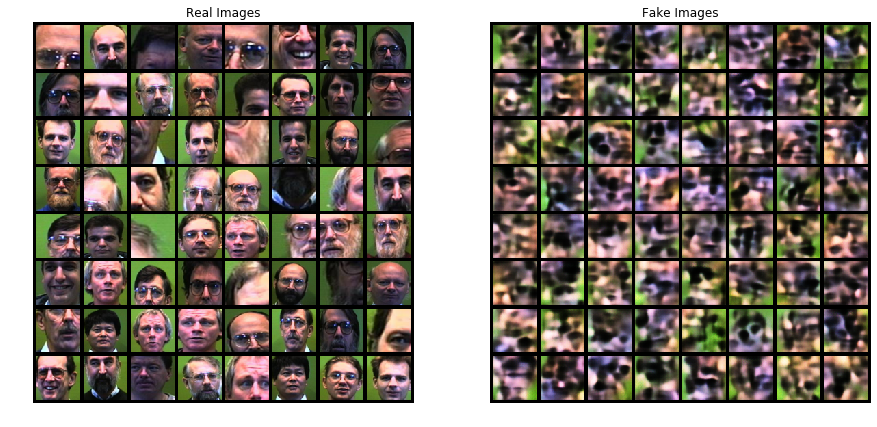

In [15]:
with torch.no_grad():
  real_batch = next(iter(Dataloader[2]))
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(torchvision.utils.make_grid(generator(test_noise).to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
  plt.show()

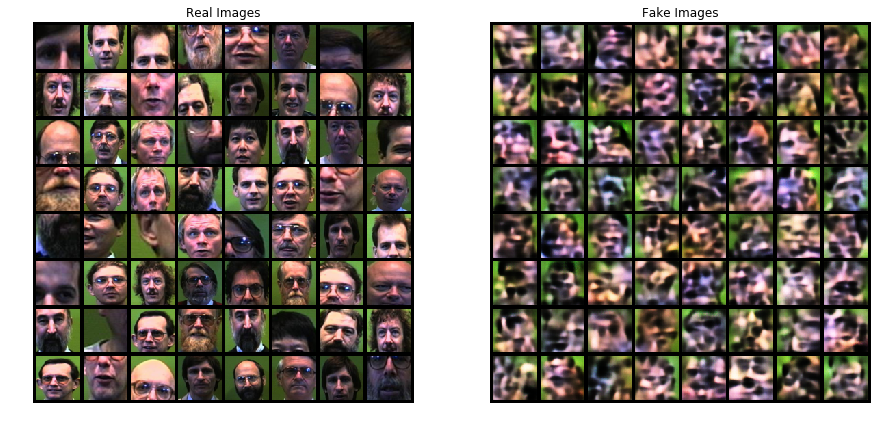

In [16]:
with torch.no_grad():
  real_batch = next(iter(Dataloader[2]))
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(torchvision.utils.make_grid(generator.decoder(torch.randn((64, 100, 1, 1), device=device)).to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
  plt.show()

In [17]:
#generator = generator.decoder
img_list = []
generator_losses = []
discriminator_losses = []
iterations = 0
for epoch in range(250):
  for j in range(len(Dataloader)):
    for i, data in enumerate(Dataloader[j], 0):
      discriminator.zero_grad()
      batch = data[0].to(device)
      batch_size = batch.size(0)
      label = torch.full((batch_size*3, ), real, device=device)
      discriminator_output = discriminator(batch).view(-1)
      real_error = loss(discriminator_output, label)
      real_error.backward()
      dx = discriminator_output.mean().item()
      latent_noise = torch.randn(batch_size, 3, 64, 64, device = device)
      fake_image = generator(latent_noise)
      label.fill_(fake)
      generator_output = discriminator(fake_image.detach()).view(-1)
      fake_error = loss(generator_output, label)
      fake_error.backward()
      DGx = generator_output.mean().item()
      total_error = real_error + fake_error
      discriminatorOptimizer.step()
      generator.zero_grad()
      label.fill_(real)
      previous_output = discriminator(fake_image).view(-1)
      generator_error = loss(previous_output, label)
      generator_error.backward()
      Gx = previous_output.mean().item()
      generatorOptimizer.step()
      generator_losses.append(generator_error.item())
      discriminator_losses.append(total_error.item())
      if(iterations%10 == 0):
        print("EPOCH:", epoch)
        print("GENERATOR LOSS:", generator_error.item())
        print("DISCRIMINATOR LOSS:", total_error.item())
      if(iterations%50 == 0):
        with torch.no_grad():
          img_list.append(torchvision.utils.make_grid(generator(test_noise).detach().cpu(), padding=True, normalize=True))
      iterations += 1
      print("EPOCH:", epoch, "DATALOADER:", j, "BATCH:",i)

EPOCH: 0
GENERATOR LOSS: 1.652274250984192
DISCRIMINATOR LOSS: 1.689787745475769
EPOCH: 0 DATALOADER: 0 BATCH: 0
EPOCH: 0 DATALOADER: 0 BATCH: 1
EPOCH: 0 DATALOADER: 0 BATCH: 2
EPOCH: 0 DATALOADER: 0 BATCH: 3
EPOCH: 0 DATALOADER: 1 BATCH: 0
EPOCH: 0 DATALOADER: 1 BATCH: 1
EPOCH: 0 DATALOADER: 1 BATCH: 2
EPOCH: 0 DATALOADER: 1 BATCH: 3
EPOCH: 0 DATALOADER: 1 BATCH: 4
EPOCH: 0 DATALOADER: 1 BATCH: 5
EPOCH: 0
GENERATOR LOSS: 3.154093027114868
DISCRIMINATOR LOSS: 1.7723462581634521
EPOCH: 0 DATALOADER: 1 BATCH: 6
EPOCH: 0 DATALOADER: 1 BATCH: 7
EPOCH: 0 DATALOADER: 1 BATCH: 8
EPOCH: 0 DATALOADER: 1 BATCH: 9
EPOCH: 0 DATALOADER: 1 BATCH: 10
EPOCH: 0 DATALOADER: 1 BATCH: 11
EPOCH: 0 DATALOADER: 1 BATCH: 12
EPOCH: 0 DATALOADER: 1 BATCH: 13
EPOCH: 0 DATALOADER: 1 BATCH: 14
EPOCH: 0 DATALOADER: 1 BATCH: 15
EPOCH: 0
GENERATOR LOSS: 2.359682083129883
DISCRIMINATOR LOSS: 1.8232862949371338
EPOCH: 0 DATALOADER: 1 BATCH: 16
EPOCH: 0 DATALOADER: 1 BATCH: 17
EPOCH: 0 DATALOADER: 2 BATCH: 0
EPOCH: 0 DA

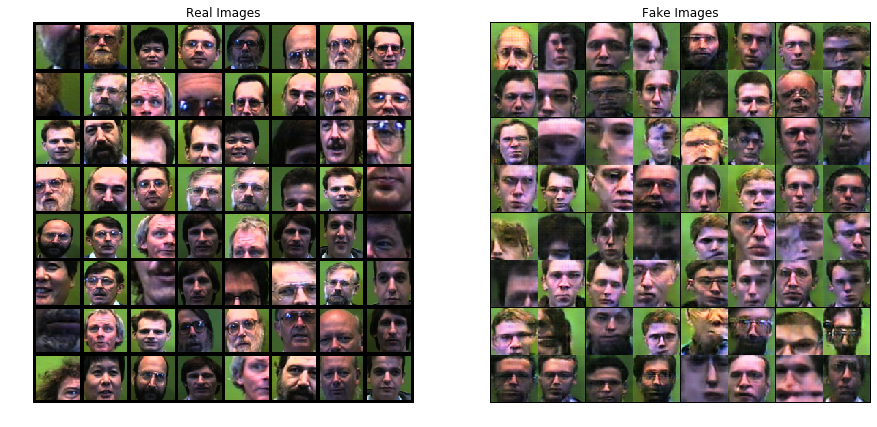

In [18]:
with torch.no_grad():
  real_batch = next(iter(Dataloader[2]))
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(img_list[-1][:32],(1,2,0)))
  plt.show()